In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [205]:
df=pd.read_csv('/content/train.csv')

Data Overview

In [206]:
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [207]:
df.shape

(5574, 2)

Check Missing values

In [208]:
df.isnull().sum()

,0
sms,0
label,0


# Text Preprocessing

Text Lowercasing

In [209]:
df['sms']=df['sms'].str.lower()

In [210]:
df.head()

,sms,label
0,"go until jurong point, crazy.. available only ...",0
1,ok lar... joking wif u oni...\n,0
2,free entry in 2 a wkly comp to win fa cup fina...,1
3,u dun say so early hor... u c already then say...,0
4,"nah i don't think he goes to usf, he lives aro...",0


Remove HTML tags

In [211]:
from bs4 import BeautifulSoup

def remove_html(text):
  soup=BeautifulSoup(text,'html.parser')
  clean_text=soup.get_text()
  clean_text=' '.join(clean_text.split())
  return clean_text

df['sms']=df['sms'].apply(remove_html)


Remove URLs

In [212]:
df['sms']=df['sms'].str.replace(r"https?://\S+|www\.\S+"," ",regex=True)

Remove Hashtag And Mention

In [213]:
df['sms']=df['sms'].str.replace(r"[@#]\w+",'',regex=True)

Remove Irrelevant Punctuation,Special Characters,Underscore,Emoji (if exist)

In [214]:
df['sms']=df['sms'].str.replace(r"[^a-z0-9!%$?\s]"," ",regex=True)

Remove whitespace

In [215]:
df['sms']=df['sms'].str.replace(r'\s+',' ',regex=True).str.strip()



In [216]:
df.head()

,sms,label
0,go until jurong point crazy available only in ...,0
1,ok lar joking wif u oni,0
2,free entry in 2 a wkly comp to win fa cup fina...,1
3,u dun say so early hor u c already then say,0
4,nah i don t think he goes to usf he lives arou...,0


Data Distribution

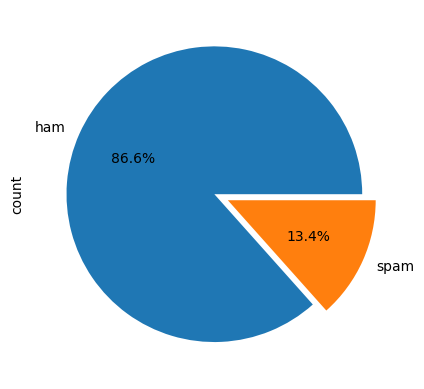

In [217]:
df['label'].value_counts().plot(kind='pie',explode = [0, 0.1],labels=['ham','spam'],autopct='%0.1f%%')
plt.show()

Word Cloud of Spam Messages

In [218]:
from wordcloud import WordCloud
wc=WordCloud(
    height=500,
    width=400,
    background_color='white',
    min_font_size=10
)

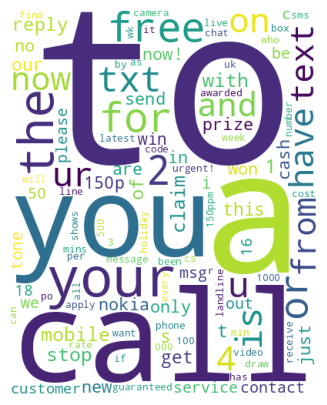

In [219]:
from collections import Counter

spam_text = df[df['label']==1]['sms'].dropna().str.cat(sep=" ")

spam_words = Counter(spam_text.split())
spam_wc = wc.generate_from_frequencies(spam_words)

plt.figure(figsize=(16,5))
plt.imshow(spam_wc)
plt.axis("off")
plt.show()


Word Cloud of Ham Messages

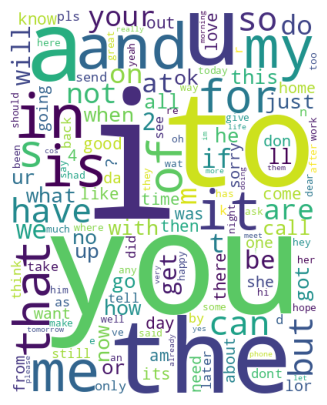

In [220]:

ham_text = df[df['label']==0]['sms'].dropna().str.cat(sep=" ")

ham_words = Counter(ham_text.split())
ham_wc = wc.generate_from_frequencies(ham_words)

plt.figure(figsize=(16,5))
plt.imshow(ham_wc)
plt.axis("off")
plt.show()

#Modeling

In [221]:
X=df['sms']
y=df['label']

In [222]:
X.head()

,sms
0,go until jurong point crazy available only in ...
1,ok lar joking wif u oni
2,free entry in 2 a wkly comp to win fa cup fina...
3,u dun say so early hor u c already then say
4,nah i don t think he goes to usf he lives arou...


In [223]:
y.head()

,label
0,0
1,0
2,1
3,0
4,0


In [224]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [225]:
X_train.shape

(4459,)

In [226]:
X_test.shape

(1115,)

Bag of words

In [227]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
bow=CountVectorizer(max_features=2000,ngram_range=(1, 2),min_df=2,max_df=0.90)

X_train_bow=bow.fit_transform(X_train).toarray()
X_test_bow=bow.transform(X_test).toarray()

Tf-IDF

In [228]:
tfidf=TfidfVectorizer(max_features=2000,ngram_range=(1, 2),min_df=2,max_df=0.90)
X_train_tfidf=tfidf.fit_transform(X_train).toarray()
X_test_tfidf=tfidf.transform(X_test).toarray()

In [229]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,ConfusionMatrixDisplay

In [230]:

mnb = MultinomialNB(alpha= 0.1,fit_prior= False)

#Multinomial Naive Bayes

In [231]:
mnb.fit(X_train_tfidf,y_train)
y_pred = mnb.predict(X_test_tfidf)

train_accuracy=accuracy_score(y_train,mnb.predict(X_train_tfidf))
test_accuracy=accuracy_score(y_test,y_pred)
print("Accuracy:",accuracy_score(y_test,y_pred))
print('Recall:',recall_score(y_test,y_pred))
print("Overfitting gap:",train_accuracy-test_accuracy)

Accuracy: 0.9668161434977578
Recall: 0.9261744966442953
Overfitting gap: 0.012775693236936059


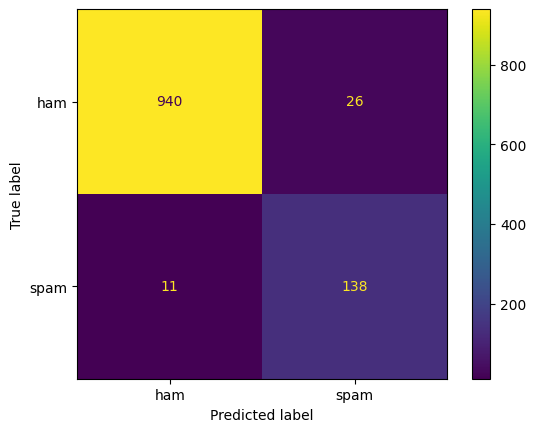

In [232]:
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['ham','spam']
)

disp.plot()
plt.show()

#Logistic Regression

In [233]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

lr.fit(X_train_tfidf, y_train)
y_pred2 = lr.predict(X_test_tfidf)
train_accuracy=accuracy_score(y_train,lr.predict(X_train_tfidf))
test_accuracy=accuracy_score(y_test,y_pred2)

print("Accuracy:",accuracy_score(y_test,y_pred2))
print('Recall:',recall_score(y_test,y_pred2))
print("Overfitting gap:",train_accuracy-test_accuracy)

Accuracy: 0.9802690582959641
Recall: 0.9463087248322147
Overfitting gap: 0.008293399654248912


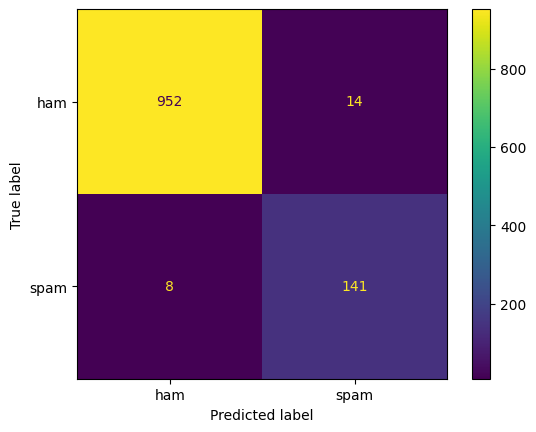

In [234]:
cm=confusion_matrix(y_test,y_pred2)
disp=ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['ham','spam']
)

disp.plot()
plt.show()

#Export Model

In [235]:
import joblib
joblib.dump(tfidf,"vectorizer.pkl")
joblib.dump(lr,"model.pkl")

In [236]:
from google.colab import files


In [237]:
files.download("vectorizer.pkl")

In [238]:
files.download("model.pkl")